## Univariate Time Series Analysis

In [1]:
from IPython.display import display, Markdown
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')

In [2]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


### Import Data

In [3]:
Data_dic_m = pd.ExcelFile('Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_filled.xlsx')

In [4]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [5]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [6]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

In [7]:
# way to retrieve method and country
method = ['Mean','Median','LOCF','NOCB','Rolling statistics']
country = list(dic_country.keys())

m_dfs[(country[0],method[0])] # stands for AUS mean data

,Employment_in_industry_male,Research_development_expenditure,Researchers in R&D,Population_labor_rate,Population_density,Foreign_direct_investment,Air_freight_million_ton_km,Container_port_traffic_TEU,Industry_value_added_current_USD,GDP_per_capita_current_USD,Final_consumption,New_business_density,Manufacturing_value added_%_of_GDP
Year,,,,,,,,,,,,,
1990,30.583793,1.949895,3899.104492,66.851833,2.221353,2.716689,1222.300049,6.401304e+06,8.961370e+10,18243.471418,2.255137e+11,12.667971,13.793444
1991,31.709999,1.949895,3899.104492,66.860327,2.249847,0.801486,1222.599976,6.401304e+06,9.012950e+10,18855.761996,2.458261e+11,12.667971,12.569810
1992,31.709999,1.949895,3899.104492,66.781131,2.277313,1.518343,1361.500000,6.401304e+06,8.745366e+10,18604.188270,2.539214e+11,12.667971,12.580159
1993,31.670000,1.949895,3899.104492,66.662599,2.299702,1.702015,1525.800049,6.401304e+06,8.372119e+10,17667.187100,2.409823e+11,12.667971,12.873184
1994,31.719999,1.949895,3899.104492,66.582205,2.324174,1.381160,1645.500000,6.401304e+06,8.644760e+10,18079.380179,2.456195e+11,12.667971,13.205020
1995,31.219999,1.949895,3899.104492,66.572593,2.352420,3.606498,1737.500000,6.401304e+06,9.723938e+10,20358.333356,2.794402e+11,12.667971,13.123677
1996,30.610001,1.663230,3355.864990,66.555719,2.383531,1.137889,1833.699951,6.401304e+06,1.041882e+11,21904.294118,3.034181e+11,12.667971,12.742416
1997,30.320000,1.949895,3899.104492,66.598197,2.410346,1.857942,1953.800049,6.401304e+06,1.097684e+11,23509.423468,3.258452e+11,12.667971,12.303665
1998,30.129999,1.514530,3382.171875,66.676387,2.435599,1.902235,1904.400024,6.401304e+06,1.013654e+11,21345.970987,3.004165e+11,12.667971,12.470748


Since all target variable in our dataset are without missing value. Here for univariate analysis, we will only keep one copy for further analysis.

### Get Target Value

In [8]:
# get target value
manufacture_y = {}
service_y = {}

def get_target_val(df, is_service):
  if not is_service:
    target = df[['Manufacturing_value added_%_of_GDP']]
    target_trim = target[~target['Manufacturing_value added_%_of_GDP'].isna()]
    return target_trim
  else:
    target = df[['Services_value_added_%_of_GDP']]
    target_trim = target[~target['Services_value_added_%_of_GDP'].isna()]
    return target_trim
for con in country: 
  manufacture_y[con] = get_target_val(m_dfs[(con,'Mean')], False)
  service_y[con] = get_target_val(s_dfs[(con,'Mean')], True)

In [9]:
manufacture_y.keys()

dict_keys(['AUS', 'BRA', 'CAN', 'CHN', 'GBR', 'IND', 'JPN', 'SGP', 'USA'])

### Target Value Visualization

#### Manufacture

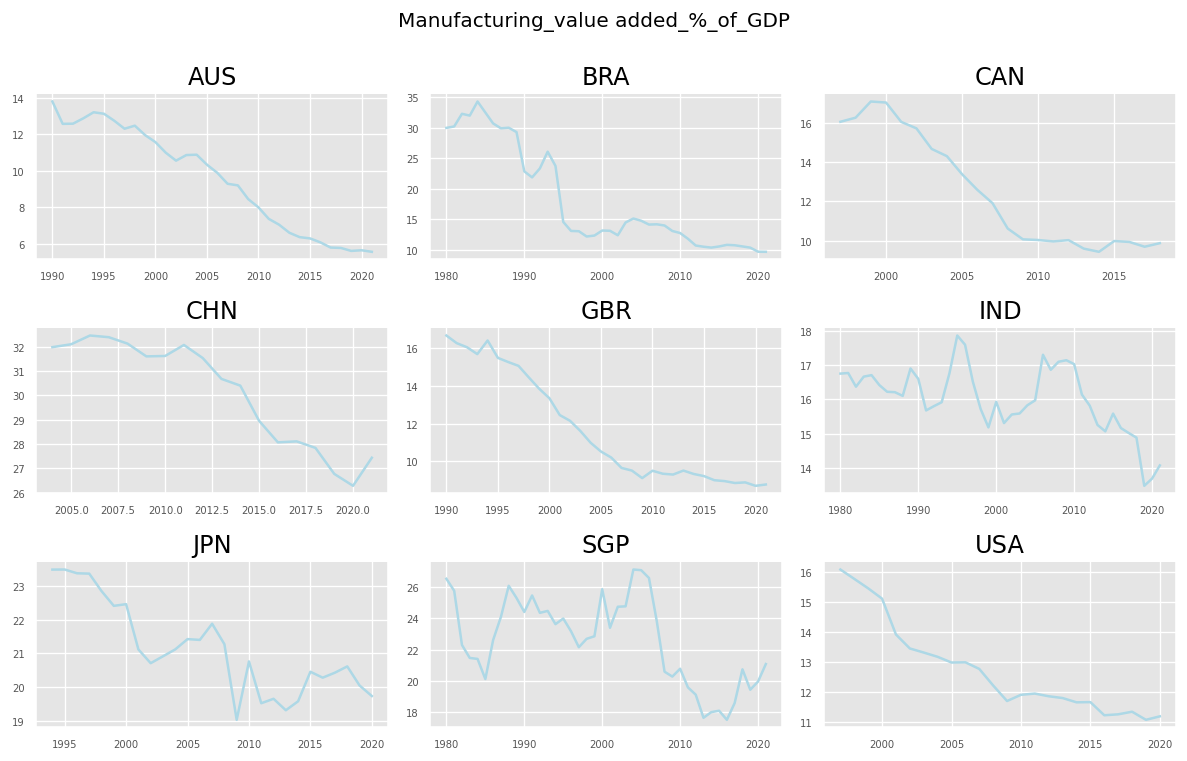

In [10]:
# for manufaturing
fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    ax.plot('Manufacturing_value added_%_of_GDP', data=manufacture_y[country[i]], color="lightblue")
    # Decorations
    ax.set_title(country[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.suptitle("Manufacturing_value added_%_of_GDP",y=1.05)
plt.tight_layout()
plt.show()

#### Service

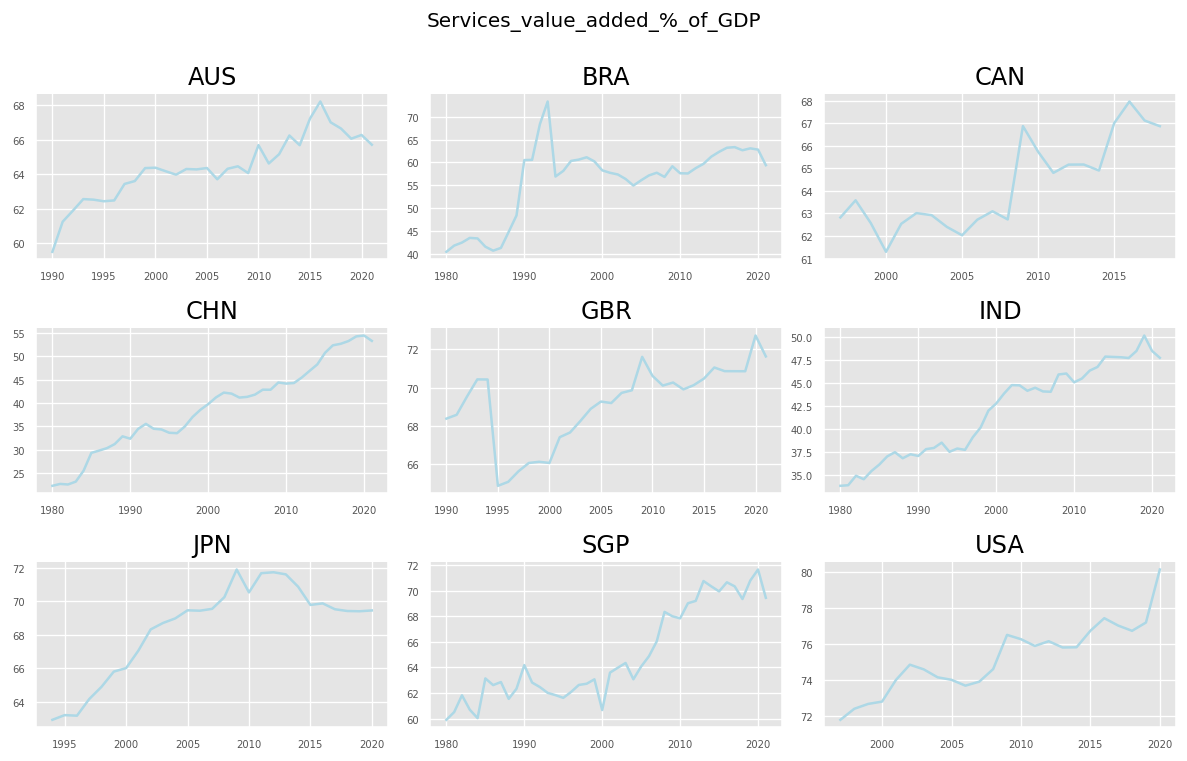

In [11]:
# for service
fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    ax.plot('Services_value_added_%_of_GDP',data= service_y[country[i]],color = "lightblue")
    # Decorations
    ax.set_title(country[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.suptitle("Services_value_added_%_of_GDP",y=1.05)
plt.tight_layout()
plt.show()

### Stationarity

#### Visualization Inspection

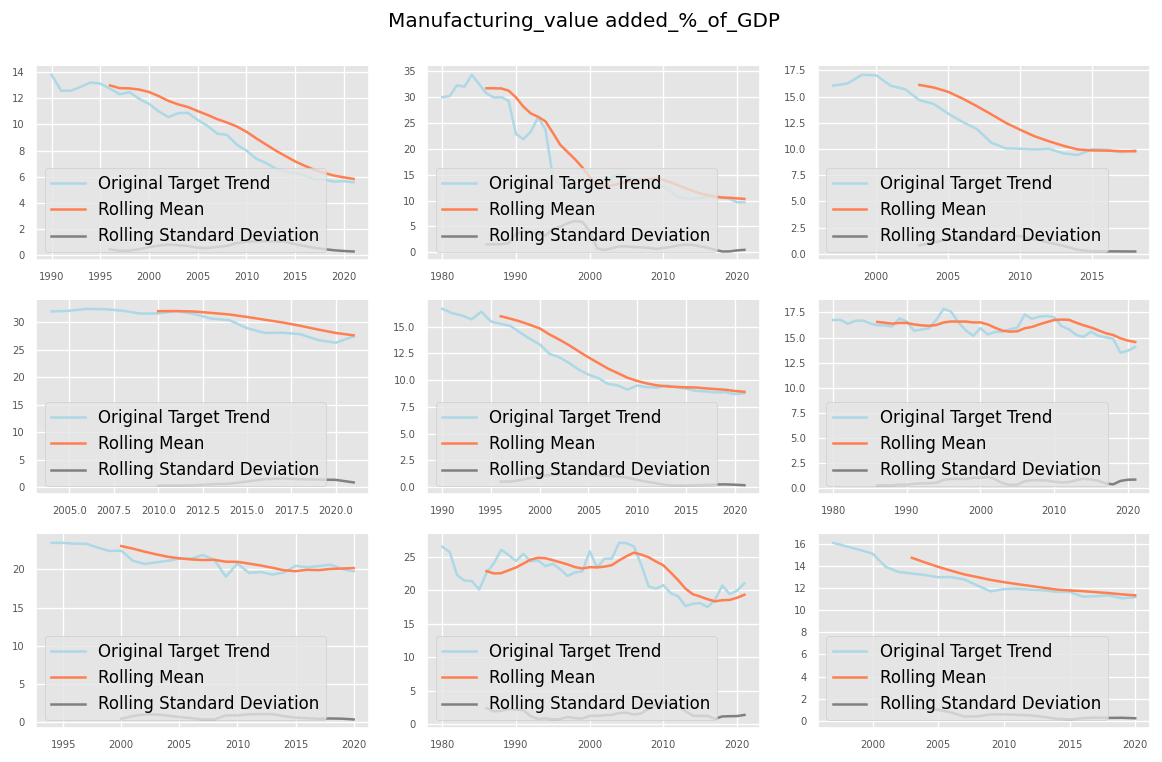

In [12]:
def vis_stationary(df,title,rolling_num = 7):
  fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
  for i, ax in enumerate(axes.flatten()):
      rolling_mean = df[country[i]].rolling(rolling_num).mean()
      rolling_std = df[country[i]].rolling(rolling_num).std()
      ax.plot(df[country[i]], color="lightblue",label="Original Target Trend")
      ax.plot(rolling_mean, color="coral", label="Rolling Mean")
      ax.plot(rolling_std, color="grey", label = "Rolling Standard Deviation")
      # Decorations
      #ax.seasonal_decompose(df[country],model='additive', period=7)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      ax.legend(loc="lower left")

  plt.suptitle(title,y=1.05)
  plt.tight_layout()

  plt.show()


vis_stationary(manufacture_y, "Manufacturing_value added_%_of_GDP")


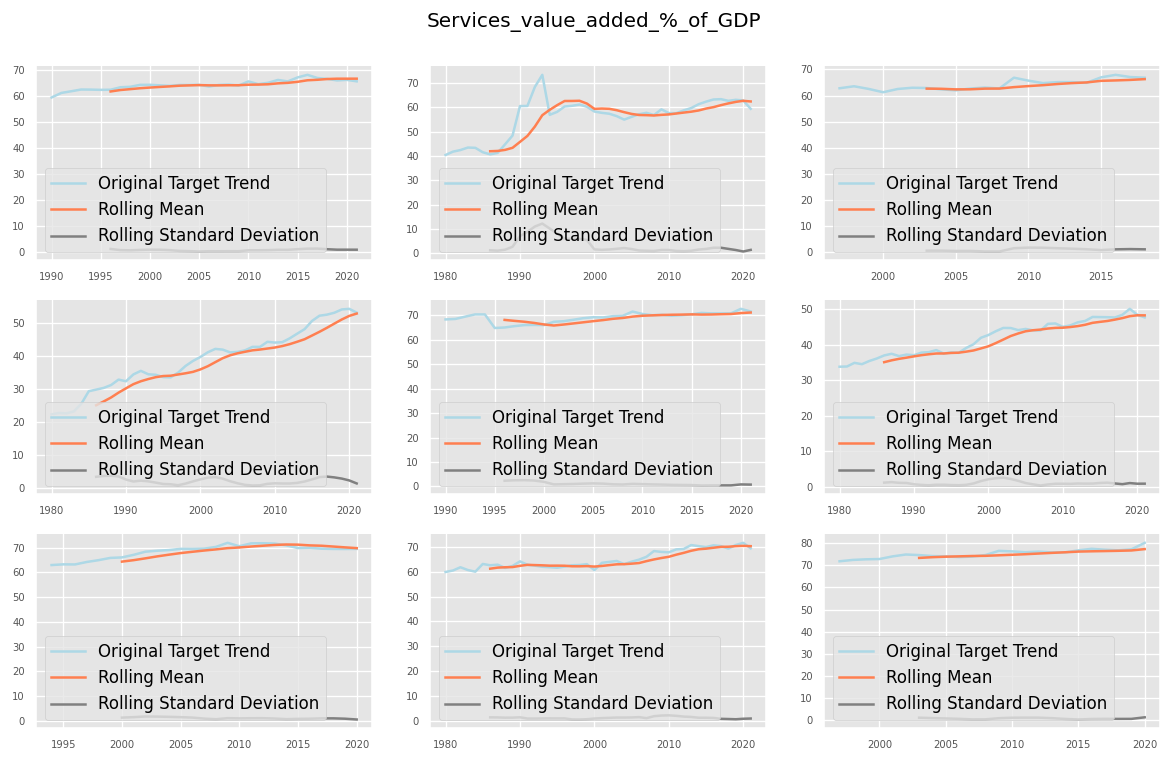

In [13]:
vis_stationary(service_y, "Services_value_added_%_of_GDP")

### ADF test

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Cannot reject Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
    print("\n")

In [16]:
for con in country:
  adfuller_test(manufacture_y[con],0.05, con)

    Augmented Dickey-Fuller Test on "AUS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5292
 No. Lags Chosen       = 0
 Critical value 1%     = -3.661
 Critical value 5%     = -2.961
 Critical value 10%    = -2.619
 => P-Value = 0.8862. Cannot reject Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "BRA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.516
 No. Lags Chosen       = 2
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.5256. Cannot reject Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

#### First Order Difference

In [17]:
diff_manu = {}
diff_ser = {}
for con in country:
  diff_manu[con] = manufacture_y[con].diff().dropna()
  diff_ser[con] = service_y[con].diff().dropna()

for con in country:
  adfuller_test(diff_manu[con],0.05, con)

    Augmented Dickey-Fuller Test on "AUS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3161
 No. Lags Chosen       = 0
 Critical value 1%     = -3.67
 Critical value 5%     = -2.964
 Critical value 10%    = -2.621
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BRA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.534
 No. Lags Chosen       = 1
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

#### Second order difference 

In [18]:
adfuller_test(diff_manu['CAN'].diff().dropna(),0.05, "CAN")
# second-diff of Canada manufature is stationary

adfuller_test(diff_manu['GBR'].diff().dropna(),0.05, "GBR")
# second-diff of Germany manufature is stationary

adfuller_test(diff_ser['CAN'].diff().dropna(),0.05, "CAN")
# second-diff of Canada service still non-stationary, therefore disgard analysis of Canada in service part

    Augmented Dickey-Fuller Test on "CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3357
 No. Lags Chosen       = 8
 Critical value 1%     = -4.223
 Critical value 5%     = -3.189
 Critical value 10%    = -2.73
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GBR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6285
 No. Lags Chosen       = 1
 Critical value 1%     = -3.689
 Critical value 5%     = -2.972
 Critical value 10%    = -2.625
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

### Autocorrelation


In [19]:
print("=======Manufaturing Autocorrelation=======")
for con in country:
  autocorrelation_lag1 =  manufacture_y[con]["Manufacturing_value added_%_of_GDP"].autocorr(lag=1)
  print(f"One Year Lag of {con}: ", autocorrelation_lag1)
print("\n")
print("=======Service Autocorrelation=======")
for con in country:
  autocorrelation_lag1 =  service_y[con]["Services_value_added_%_of_GDP"].autocorr(lag=1)
  print(f"One Year Lag of {con}: ", autocorrelation_lag1)

=======Manufaturing Autocorrelation=======
One Year Lag of AUS:  0.9924885267251866
One Year Lag of BRA:  0.9705762022513933
One Year Lag of CAN:  0.9826457423593227
One Year Lag of CHN:  0.9586851566326937
One Year Lag of GBR:  0.9932969057027103
One Year Lag of IND:  0.8220502897041175
One Year Lag of JPN:  0.8470591152229123
One Year Lag of SGP:  0.859512109144477
One Year Lag of USA:  0.983625139802899


=======Service Autocorrelation=======
One Year Lag of AUS:  0.9184916714686304
One Year Lag of BRA:  0.891836143786259
One Year Lag of CAN:  0.8013451362151703
One Year Lag of CHN:  0.9934692226938163
One Year Lag of GBR:  0.8225060920740754
One Year Lag of IND:  0.9871444268079823
One Year Lag of JPN:  0.969898405687662
One Year Lag of SGP:  0.9446066751258873
One Year Lag of USA:  0.8938524099568661


### Model Fitting

#### Train-test split

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

In [21]:
def split_train_test(df, valid_num = 5):
    train = df[:-valid_num]
    valid = df[-valid_num:]
    return train, valid

train_manu = {}
valid_manu = {}
train_ser = {}
valid_ser = {}
for con in country:
    train_manu[con], valid_manu[con]= split_train_test(manufacture_y[con])
    train_ser[con], valid_ser[con]= split_train_test(service_y[con])

##### ACF and PACF plot

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsap

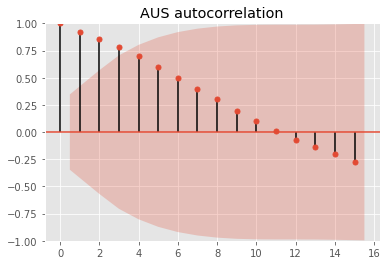

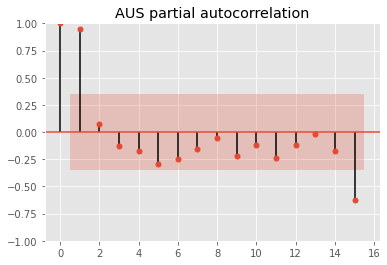

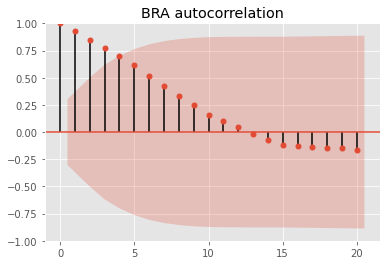

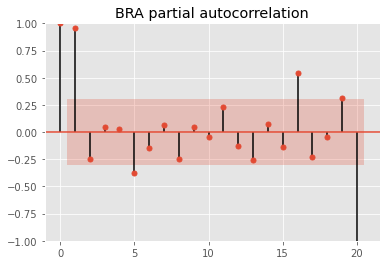

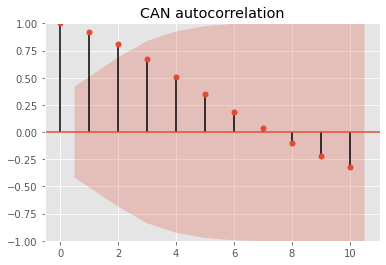

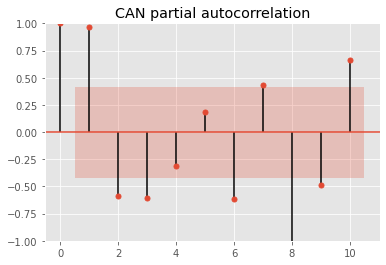

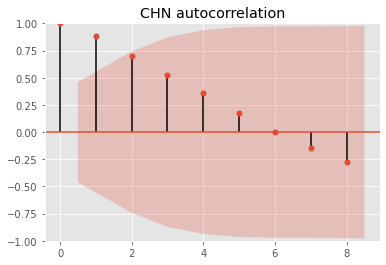

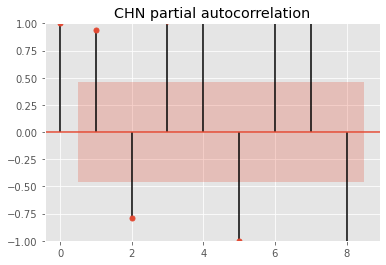

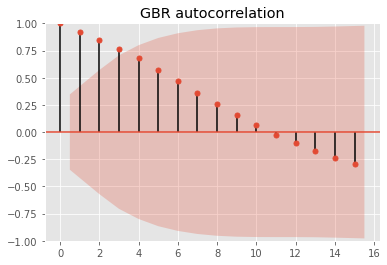

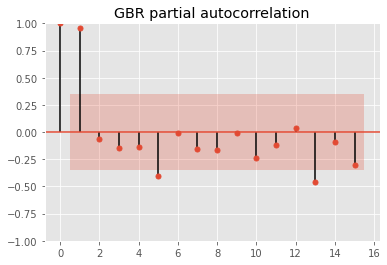

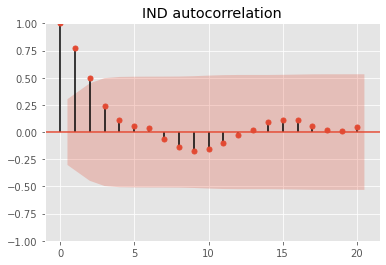

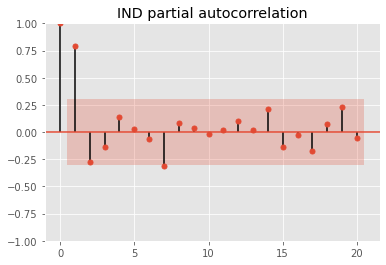

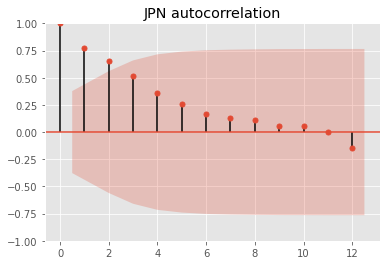

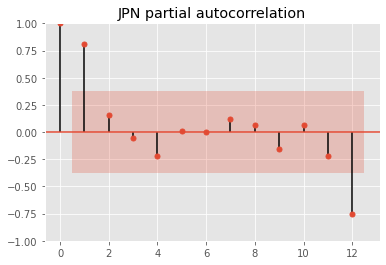

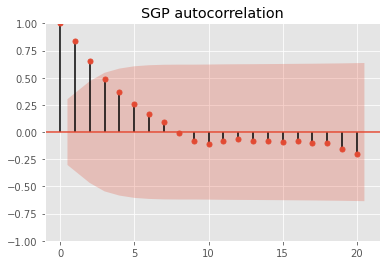

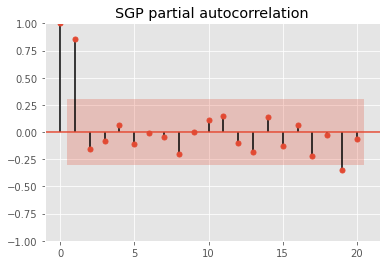

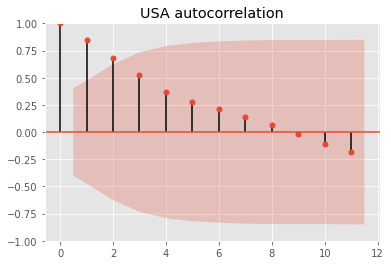

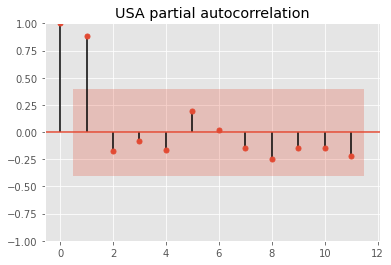

In [22]:
def show_acf_pacf(df, con, val):
    lag = df[con][val].shape[0]//2 - 1
    plot_acf(df[con][val],lags = lag,title = con + " autocorrelation")
    plot_pacf(df[con][val],lags = lag,title = con + " partial autocorrelation")

for con in country:
    show_acf_pacf(manufacture_y, con, "Manufacturing_value added_%_of_GDP")

#### AR,MA, ARMA, ARIMA

Performing univariate time series analysis using auto.arima to determine the best practice model.

In [23]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from pmdarima.arima import auto_arima
manu_model = {}
ser_model = {}
def set_auto_arima(train, con, manu, dic):
  model = auto_arima(train[con][manu],trace=True, error_action='ignore', suppress_warnings=True)
  model.fit(train[con][manu])
  dic[con] = model

  # forecast = model.predict(n_periods=len(test))
  # forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction']) 
print("======= Auto ARIMA for manufacture=======")
for con in country:
  print(f"======={con}=======")
  set_auto_arima(train_manu,con, "Manufacturing_value added_%_of_GDP",manu_model)
  print("\n")

print("======= Auto ARIMA for service=======")
for con in country:
  print(f"======={con}=======")
  set_auto_arima(train_ser,con, "Services_value_added_%_of_GDP",ser_model)
  print("\n")

======= Auto ARIMA for manufacture=======
=======AUS=======
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.706, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.132, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24.969, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35.555, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.967, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.981 seconds


=======BRA=======
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=161.436, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=160.229, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160.738, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=159.279, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=160.432, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

#### Forecasting

In [25]:
forecast = manu_model['CHN'].predict(n_periods=len(valid_manu['CHN'])).reset_index().drop(['index'],axis = 1)
forecast['Year'] = valid_manu['CHN'].index
forecast.set_index(['Year'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,0
Year,
2017,27.714386
2018,27.645154
2019,27.725549
2020,27.879219
2021,28.063819


In [26]:
forecast_manu = {}
forecast_ser = {}
def forecast_arima(model, valid,con, manu):
  forecast = model.predict(n_periods=len(valid)).reset_index().drop(['index'],axis = 1)
  forecast['Year'] = valid.index
  forecast = forecast.set_index(['Year'])
  forecast = forecast.rename(columns={0: "Prediction"})
  manu[con] = forecast

for con in country:
  forecast_arima(manu_model[con],valid_manu[con],con, forecast_manu)
  forecast_arima(ser_model[con],valid_ser[con],con, forecast_ser)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is availa

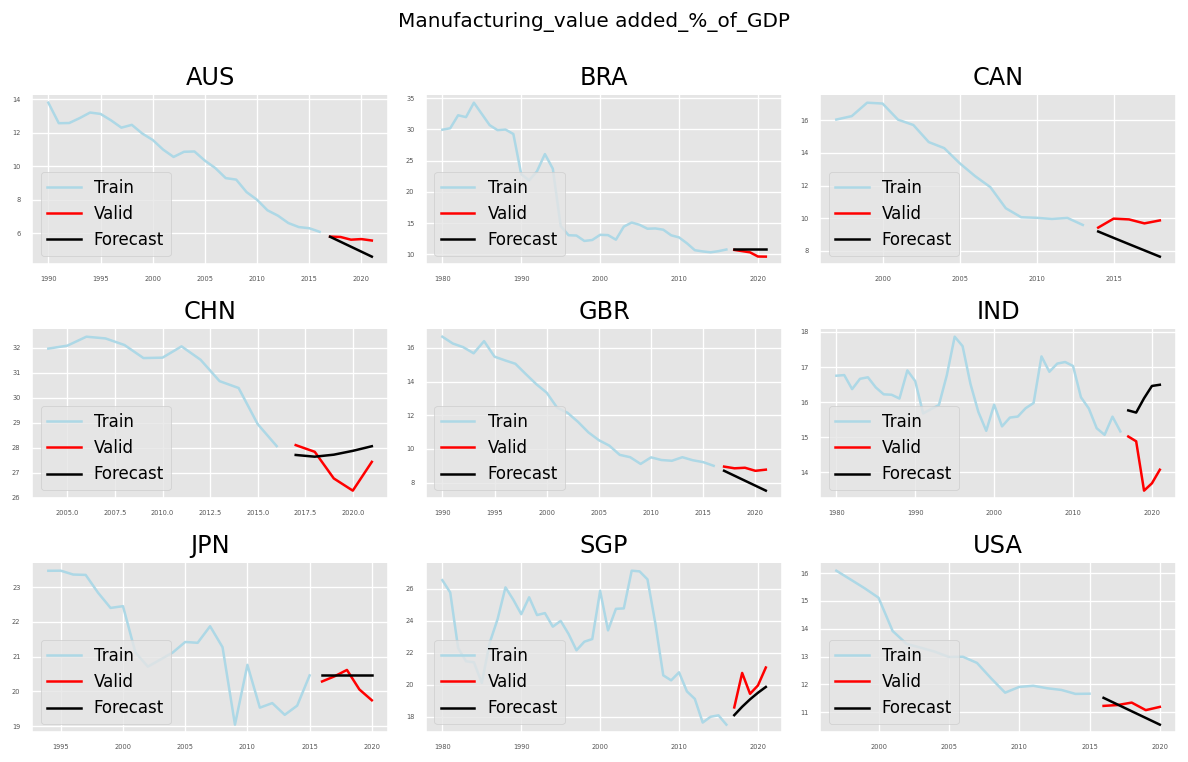

In [27]:
# for manufaturing
fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    ax.plot(train_manu[country[i]],color = "lightblue",label="Train")
    ax.plot(valid_manu[country[i]],color = "red",label="Valid")
    ax.plot(forecast_manu[country[i]],color = "black",label="Forecast")
    # Decorations
    ax.set_title(country[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)
    ax.legend(loc="lower left")

plt.suptitle("Manufacturing_value added_%_of_GDP",y=1.05)
plt.tight_layout()
plt.show()

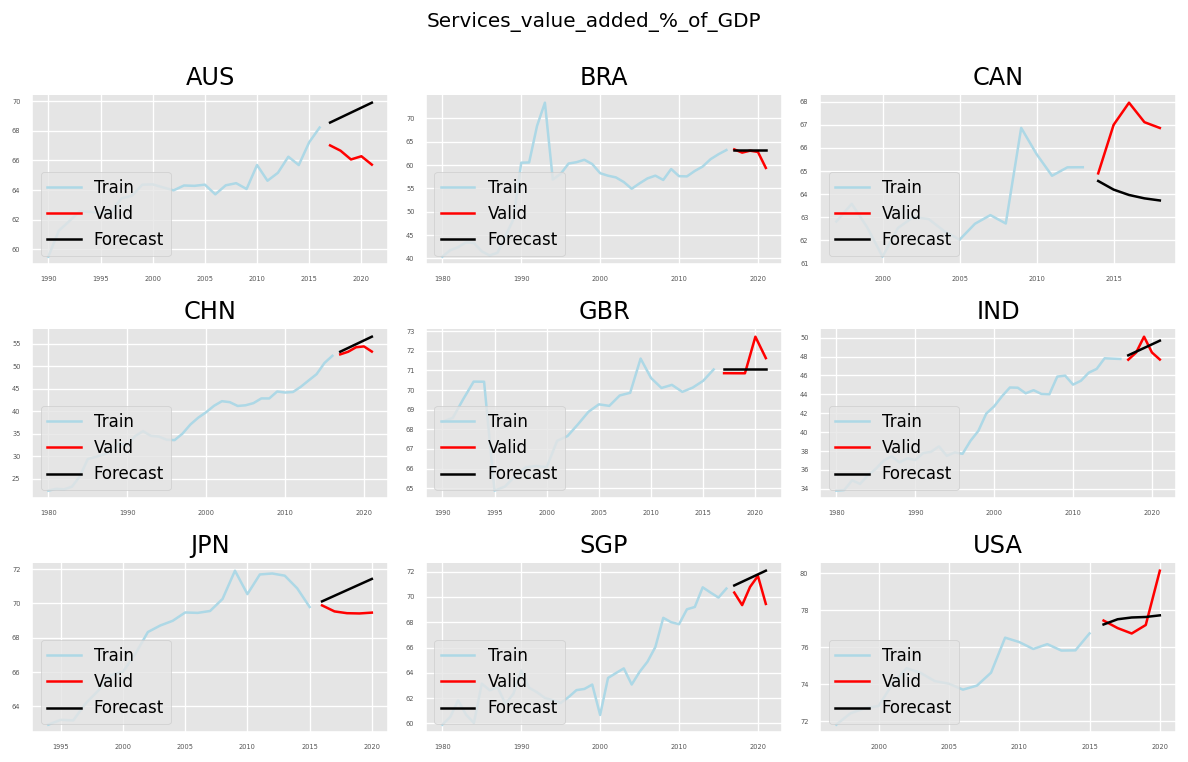

In [28]:
# for service
fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    ax.plot(train_ser[country[i]],color = "lightblue",label="Train")
    ax.plot(valid_ser[country[i]],color = "red",label="Valid")
    ax.plot(forecast_ser[country[i]],color = "black",label="Forecast")
    # Decorations
    ax.set_title(country[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)
    ax.legend(loc="lower left")

plt.suptitle("Services_value_added_%_of_GDP",y=1.05)
plt.tight_layout()
plt.show()

### Evaluation

In [38]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [51]:
m_metrics = {}
s_metrics = {}
for con in country:
  mae = mean_absolute_error(valid_manu[con], forecast_manu[con])
  mse = mean_squared_error(valid_manu[con],forecast_manu[con])
  rmse = sqrt(mean_squared_error(valid_manu[con],forecast_manu[con]))
  eval = [mae,mse,rmse]
  #print(mae, mse, rmse, con)
  m_metrics[con] = eval

  mae = mean_absolute_error(valid_ser[con], forecast_ser[con])
  mse = mean_squared_error(valid_ser[con], forecast_ser[con])
  rmse = sqrt(mean_squared_error(valid_ser[con],forecast_ser[con]))
  eval = [mae,mse,rmse]
  #print(mae, mse, rmse, con)
  s_metrics[con] = eval

In [55]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'MSE','RMSE']

m_eval

s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE', 'MSE','RMSE']
m_eval

,MAE,MSE,RMSE
AUS,0.485452,0.349528,0.591209
BRA,0.672809,0.650792,0.806717
CAN,1.360725,2.278860,1.509589
CHN,0.752271,0.806204,0.897889
GBR,0.717971,0.636999,0.798122
IND,1.880092,4.351989,2.086142
JPN,0.295330,0.145927,0.382004
SGP,0.922174,1.298981,1.139728
USA,0.307420,0.133465,0.365328


In [56]:
s_eval

,MAE,MSE,RMSE
AUS,2.881403,9.132429,3.021991
BRA,1.010412,3.023441,1.738805
CAN,2.710705,8.915936,2.985956
CHN,1.354780,2.860637,1.691342
GBR,0.565637,0.647046,0.804392
IND,0.922334,1.276192,1.129687
JPN,1.228572,1.879361,1.370898
SGP,1.171764,2.228247,1.492731
USA,0.880883,1.408982,1.187005
